In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests as rq
import time
from shutil import copyfile
from pymongo import MongoClient
import re
from bson.objectid import ObjectId
import pprint
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from bokeh.layouts import row
from bokeh.io import output_notebook

output_notebook()
% matplotlib inline

plt.style.use('seaborn-muted')
sns.set_palette(sns.color_palette("Paired",20))

Loading BokehJS ...

In [2]:
client = MongoClient()
db = client['repos-database']
dockerfiles = db['dockerfile_repos']
repos = db['repos']

In [3]:
cursorRepos = repos.find()
cursorDockerfiles = dockerfiles.find()
# Expand the cursor and construct the DataFrame
dfDockerfiles = pd.DataFrame(list(cursorDockerfiles))
dfRepos =  pd.DataFrame(list(cursorRepos))
dfRepos.head()

,_id,branches,commits,created_at,default_branch,forked_from,forks,languagues,license,name,readme,releases,stars,updated_at,url,watchers
0,5bb3d531b1652b5d9040dac5,1,15,2014-08-26 16:36:06,master,None,0,{'Shell': 1.0},MIT,SuperCowPowers/workbench-docker,404: Not Found\n,0,3,2018-01-29 10:46:32,https://github.com/SuperCowPowers/workbench-do...,3
1,5bb3d531b1652b5d9040dac6,1,9,2016-09-02 19:26:34,master,None,0,"{'Java': 0.8759999999999999, 'PLSQL': 0.100999...",Apache-2.0,MrocznyBanan/springboot-example,# springboot-example\n\n(springboot & mybatis ...,0,0,2016-09-27 12:48:54,https://github.com/MrocznyBanan/springboot-exa...,0
2,5bb3d531b1652b5d9040dac7,1,50,2017-04-06 09:46:33,master,None,2,"{'Go': 0.9670000000000001, 'Shell': 0.01800000...",MIT,ci-pipeline/cloudformation-resource,# CloudFormation Resource\n\nThis is a Concour...,0,4,2017-10-30 07:48:41,https://github.com/ci-pipeline/cloudformation-...,4
3,5bb3d531b1652b5d9040dac8,1,3,2015-12-01 17:13:33,master,None,0,None,MIT,Bunk/docker-nodemon,# docker-nodemon\nThe simplest possible Docker...,0,0,2015-12-01 17:13:33,https://github.com/Bunk/docker-nodemon/tree/ma...,0
4,5bb3d532b1652b5d9040dace,1,14,2015-10-01 15:28:21,master,None,0,"{'Python': 0.7170000000000001, 'Shell': 0.259,...",MIT,BartGo/transition-drafts,# transition-drafts\n,0,0,2016-05-25 19:55:50,https://github.com/BartGo/transition-drafts/tr...,0


In [4]:
lang = dfRepos.languagues.apply(pd.Series)
dfRepos['MaxLang'] = lang.idxmax(axis=1)
dfRepos['QtdLang'] = lang.count(axis=1)

In [5]:
dfDockerfiles = dfDockerfiles[dfDockerfiles['config']!={}]
dfWithDockerfiles = pd.merge(dfRepos, dfDockerfiles, left_on='_id', right_on='repo')
dfWithDockerfiles

,_id_x,branches,commits,created_at,default_branch,forked_from,forks,languagues,license,name,...,updated_at,url,watchers,MaxLang,QtdLang,_id_y,config,path,repo,repoName
0,5bb3d531b1652b5d9040dac5,1,15,2014-08-26 16:36:06,master,None,0,{'Shell': 1.0},MIT,SuperCowPowers/workbench-docker,...,2018-01-29 10:46:32,https://github.com/SuperCowPowers/workbench-do...,3,Shell,1,5bb900a7b1652b4f8165b0f9,{'Config1': {'FROM': ' phusion/baseimage:...,Dockerfile,5bb3d531b1652b5d9040dac5,SuperCowPowers/workbench-docker
1,5bb3d531b1652b5d9040dac6,1,9,2016-09-02 19:26:34,master,None,0,"{'Java': 0.8759999999999999, 'PLSQL': 0.100999...",Apache-2.0,MrocznyBanan/springboot-example,...,2016-09-27 12:48:54,https://github.com/MrocznyBanan/springboot-exa...,0,Java,4,5bb900a8b1652b4f8165b0fe,"{'Config1': {'FROM': 'airhacks/java', 'MAINTAI...",Dockerfile,5bb3d531b1652b5d9040dac6,MrocznyBanan/springboot-example
2,5bb3d531b1652b5d9040dac7,1,50,2017-04-06 09:46:33,master,None,2,"{'Go': 0.9670000000000001, 'Shell': 0.01800000...",MIT,ci-pipeline/cloudformation-resource,...,2017-10-30 07:48:41,https://github.com/ci-pipeline/cloudformation-...,4,Go,3,5bb900a7b1652b4f8165b0fb,"{'Config1': {'FROM': 'alpine', 'RUN': ['mkdir ...",Dockerfile,5bb3d531b1652b5d9040dac7,ci-pipeline/cloudformation-resource
3,5bb3d531b1652b5d9040dac8,1,3,2015-12-01 17:13:33,master,None,0,None,MIT,Bunk/docker-nodemon,...,2015-12-01 17:13:33,https://github.com/Bunk/docker-nodemon/tree/ma...,0,NaN,0,5bb900adb1652b4f8165b132,"{'Config1': {'FROM': 'node:5.1', 'RUN': ['npm ...",Dockerfile,5bb3d531b1652b5d9040dac8,Bunk/docker-nodemon
4,5bb3d532b1652b5d9040dace,1,14,2015-10-01 15:28:21,master,None,0,"{'Python': 0.7170000000000001, 'Shell': 0.259,...",MIT,BartGo/transition-drafts,...,2016-05-25 19:55:50,https://github.com/BartGo/transition-drafts/tr...,0,Python,3,5bb900aab1652b4f8165b10e,"{'Config1': {'FROM': 'python:2-onbuild', 'CMD'...",Dockerfile,5bb3d532b1652b5d9040dace,BartGo/transition-drafts
5,5bb3d532b1652b5d9040dacf,2,2,2016-01-28 21:29:53,master,None,0,"{'PHP': 0.7170000000000001, 'JavaScript': 0.14...",GPL-2.0,OSTraining/alledia-docker-wordpress-installed,...,2016-03-01 18:48:30,https://github.com/OSTraining/alledia-docker-w...,0,PHP,3,5bb900a9b1652b4f8165b101,"{'Config1': {'FROM': 'alledia/lamp', 'MAINTAIN...",Dockerfile,5bb3d532b1652b5d9040dacf,OSTraining/alledia-docker-wordpress-installed
6,5bb3d531b1652b5d9040dac9,1,12,2017-07-24 06:41:24,master,None,0,"{'PHP': 0.769, 'HTML': 0.19699999999999998, 'M...",MIT,FridayLabs/service,...,2017-07-26 11:53:44,https://github.com/FridayLabs/service/tree/master,1,PHP,3,5bb900afb1652b4f8165b145,{'Config1': {'FROM': 'fridaylabs/image:latest'...,Dockerfile,5bb3d531b1652b5d9040dac9,FridayLabs/service
7,5bb3d531b1652b5d9040daca,1,7,2016-08-21 08:05:37,master,None,0,"{'JavaScript': 0.526, 'TypeScript': 0.28600000...",MIT,WebSamurai/MusicApp,...,2016-08-21 08:06:55,https://github.com/WebSamurai/MusicApp/tree/ma...,0,JavaScript,4,5bb900b8b1652b4f8165b1b0,"{'Config1': {'FROM': 'node:latest', 'RUN': ['m...",Dockerfile,5bb3d531b1652b5d9040daca,WebSamurai/MusicApp
8,5bb3d531b1652b5d9040dacb,6,231,2015-02-11 12:49:17,master,None,0,"{'C++': 0.8320000000000001, 'OCaml': 0.15}",BSD-3-Clause,Wassasin/roerei,...,2018-06-10 14:18:26,https://github.com/Wassasin/roerei/tree/master,0,C++,2,5bb900adb1652b4f8165b137,"{'Config1': {'FROM': 'debian:stretch', 'RUN': ...",Dockerfile,5bb3d531b1652b5d9040dacb,Wassasin/roerei
9,5bb3d531b1652b5d9040dacc,7,739,2015-01-25 23:55:25,master,None,0,"{'JavaScript': 0.956, 'CSS': 0.025, 'HTML': 0....",View license,AreaCommunicationsCEN3031/main-repository,...,2015-02-28 18:18:34,https://github.com/AreaCommunicationsCEN3031/m...,1,JavaScript,3,5bb900a8b1652b4f8165b0fd,"{'Config1': {'FROM': 'dockerfile/nodejs', 'MAI...",Dockerfile,5bb3d531b1652b5d9040dacc,AreaCommunicationsCEN3031/main-repository


In [7]:
gp = dfRepos.filter(['name'],axis=1)
gp = dfRepos['name'].apply(lambda x: pd.Series({'name':x,'dfCount':dfDockerfiles[dfDockerfiles['repoName']==x]['repoName'].count()}))
# count = []
# for row in gp:
#     count.append(dfDockerfiles[dfDockerfiles['repoName']==row[1]]['repoName'].count())
# gp['dfCount'] = count
gp.sort_values('dfCount')

# gp = dfWithDockerfiles.groupby('name').count()
# 
# gp
# aggReposDF = gp.apply(lambda x: pd.Series({'media':x.mean(), 'desvp':x.std()}, 
#                               index=['media','desvp']),axis=1)
# aggReposDF

,name,dfCount
119143,nonmadden/os,0
106902,keycloak/keycloak,0
106889,googleapis/cloud-trace-nodejs,0
9646,chrisseto/waterbutler,0
9670,onetimesecret/onetimesecret,0
9672,driusan/dainit,0
9695,ricardobsilva/desafio-frontend-safety,0
9701,Code4SA/aleph,0
106751,godwinamila/demosamples,0
106747,hubotio/generator-hubot,0


In [8]:
gp = gp.rename(index=str, columns={"dfCount": "df_qtd"})
gp2 = gp[gp['df_qtd']!=0]
dfRepoDF = pd.merge(dfRepos, gp2, on='name')
info = {"Moda": dfRepoDF['df_qtd'].mode(),
        "Mediana": dfRepoDF['df_qtd'].median(),
        "Média": dfRepoDF['df_qtd'].mean(),
        "desvp": dfRepoDF['df_qtd'].std(),
        'amplitude': dfRepoDF['df_qtd'].ptp(),
        'min': dfRepoDF['df_qtd'].min(),
        'max': dfRepoDF['df_qtd'].max(),
        '1º Quartil': dfRepoDF['df_qtd'].quantile(0.25),
        '2º Quartil': dfRepoDF['df_qtd'].quantile(0.5),
        '3º Quartil': dfRepoDF['df_qtd'].quantile(0.75),
        '90º Percentil': dfRepoDF['df_qtd'].quantile(0.9),
        '95º Percentil': dfRepoDF['df_qtd'].quantile(0.95)
       }
test = pd.Series(info)
display(test)

Moda             0    1
dtype: int64
Mediana                            1
Média                        4.45581
desvp                        50.6149
amplitude                      12298
min                                1
max                            12299
1º Quartil                         1
2º Quartil                         1
3º Quartil                         2
90º Percentil                      6
95º Percentil                     13
dtype: object

In [8]:
dfDockerfiles[dfDockerfiles['config']=={}]

,_id,config,path,repo,repoName


In [9]:
dfConfigs = dfWithDockerfiles.config.apply(pd.Series)
dfConfigs.fillna(value=0,inplace=True)
dfConfigs.head()

,Config1,Config2,Config3,Config4,Config5,Config6,Config7,Config8,Config9,Config10,...,Config17,Config18,Config19,Config20,Config21,Config22,Config23,Config24,Config25,Config26
0,"{'FROM': ' phusion/baseimage:0.9.13', 'MA...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"{'FROM': 'airhacks/java', 'MAINTAINER': ['Mroc...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"{'FROM': 'alpine', 'RUN': ['mkdir /lib64 && ln...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"{'FROM': 'node:5.1', 'RUN': ['npm install -g n...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"{'FROM': 'python:2-onbuild', 'CMD': ['[ ""pytho...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
totalOutOfBestPractices = []
totalLayersCount = []
for row in dfConfigs.itertuples():
    i = 1
    outOfBestPractices = []
    DFLayersCount = {}
    sumLayers = 0
    
    while i < len(row) and row[i] != 0:
        layersCount = {}
        config= row[i]
        for column in config.keys():
            values = config.get(column)
            if column == "RUN":
                for v in values:
                    layersCount.setdefault('RUN', 0)
                    layersCount['RUN'] += 1
                    if 'apt-get update' in v and 'apt-get install' not in v:
                        outOfBestPractices.append('RUN apt-get update without install')
                    if ' | ' in v and 'set -o pipefail &&' not in v:
                        outOfBestPractices.append('RUN with pipe and without fail cautions')
                    if 'cd ' in v:
                        outOfBestPractices.append('RUN with cd')
                    if 'sudo ' in v:
                        outOfBestPractices.append('RUN with sudo')
                    if 'apt-get upgrade' in v or 'dist-upgrade' in v:
                        outOfBestPractices.append('RUN with apt-get upgrade or dist-upgrade')
            if column == "COPY":
                for v in values:
                    layersCount.setdefault('COPY', 0)
                    layersCount['COPY'] += 1
            if column == "ADD":
                for v in values:
                    layersCount.setdefault('ADD', 0)
                    layersCount['ADD'] += 1
                    if 'http://' in v or 'https://' in v:
                        outOfBestPractices.append('ADD with remote address')
                    if '.tar' not in v:
                        outOfBestPractices.append('ADD without compressed file')
            if column == "WORKDIR":
                for v in values:
                    if not v.startswith('/'):
                        outOfBestPractices.append('WORKDIR without absolute path')
            if column == "CMD":
                for v in values:
                    layersCount.setdefault('CMD', 0)
                    layersCount['CMD'] += 1
        DFLayersCount["Config"+str(i)]=layersCount
        i += 1
        if (i >= len(row) or i < len(row) and row[i] == 0) and sumLayers > 0:
            if sumLayers < sum(layersCount.values()) :
                outOfBestPractices.append('Multi-stage build with last stage having more layers than previous stages')
        else:
            sumLayers += sum(layersCount.values())
    totalLayersCount.append(DFLayersCount)
    if not outOfBestPractices :
        totalOutOfBestPractices.append(None)
    else:
        totalOutOfBestPractices.append(list(set(outOfBestPractices)))
dfConfigs["ReasonOutBestPractices"] = totalOutOfBestPractices
dfConfigs.head()

,Config1,Config2,Config3,Config4,Config5,Config6,Config7,Config8,Config9,Config10,...,Config18,Config19,Config20,Config21,Config22,Config23,Config24,Config25,Config26,ReasonOutBestPractices
0,"{'FROM': ' phusion/baseimage:0.9.13', 'MA...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[ADD without compressed file, RUN with pipe an..."
1,"{'FROM': 'airhacks/java', 'MAINTAINER': ['Mroc...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[ADD without compressed file]
2,"{'FROM': 'alpine', 'RUN': ['mkdir /lib64 && ln...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[ADD without compressed file]
3,"{'FROM': 'node:5.1', 'RUN': ['npm install -g n...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None
4,"{'FROM': 'python:2-onbuild', 'CMD': ['[ ""pytho...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,None


In [11]:
def label_best_practices(row):
    if not row['ReasonOutBestPractices']:
        return 1
    return 0
    
dfConfigs['BestPractices'] = dfConfigs.apply(lambda row: label_best_practices(row), axis=1)
dfConfigs['MaxLang'] = dfWithDockerfiles['MaxLang']
dfConfigs.head()

,Config1,Config2,Config3,Config4,Config5,Config6,Config7,Config8,Config9,Config10,...,Config20,Config21,Config22,Config23,Config24,Config25,Config26,ReasonOutBestPractices,BestPractices,MaxLang
0,"{'FROM': ' phusion/baseimage:0.9.13', 'MA...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,"[ADD without compressed file, RUN with pipe an...",0,Shell
1,"{'FROM': 'airhacks/java', 'MAINTAINER': ['Mroc...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,[ADD without compressed file],0,Java
2,"{'FROM': 'alpine', 'RUN': ['mkdir /lib64 && ln...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,[ADD without compressed file],0,Go
3,"{'FROM': 'node:5.1', 'RUN': ['npm install -g n...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,None,1,NaN
4,"{'FROM': 'python:2-onbuild', 'CMD': ['[ ""pytho...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,None,1,Python


In [12]:
dfConfigs['BestPractices'].value_counts()
dfWithDockerfiles['TotalDockerFiles'] = dfConfigs.apply(lambda row: label_best_practices(row), axis=1)
dfWithDockerfiles['ReasonOutBestPractices'] = totalOutOfBestPractices
dfWithDockerfiles['TotalDockerFiles'].value_counts()

0    255817
1    163504
Name: TotalDockerFiles, dtype: int64

In [13]:
#dfGroupbyLangSum = dfWithDockerfiles[['MaxLang','HaveBestPractices']].groupby('MaxLang').sum()
dfGroupbyLangCount = dfWithDockerfiles[['MaxLang','TotalDockerFiles']].groupby('MaxLang').count()
dfGroupbyLangCount['HaveBestPractices'] = dfWithDockerfiles[['MaxLang','TotalDockerFiles']].groupby('MaxLang').sum()
dfGroupbyLangCount['DontHaveBestPractices'] = dfGroupbyLangCount.apply(lambda row: row['TotalDockerFiles'] - row['HaveBestPractices'], axis=1)
dfGroupbyLangCount

,TotalDockerFiles,HaveBestPractices,DontHaveBestPractices
MaxLang,,,
AGS Script,42,39,3
ANTLR,1,1,0
API Blueprint,7,3,4
APL,1,0,1
ASP,1,0,1
ATS,1,1,0
ActionScript,1,1,0
Ada,5,3,2
Agda,1,0,1


,TotalDockerFiles,HaveBestPractices,DontHaveBestPractices
MaxLang,,,
ApacheConf,376,142,234
Assembly,323,184,139
C,8915,2812,6103
C#,2193,1435,758
C++,8706,2323,6383
CSS,2668,1183,1485
Clojure,634,295,339
CoffeeScript,1059,275,784
ColdFusion,131,81,50


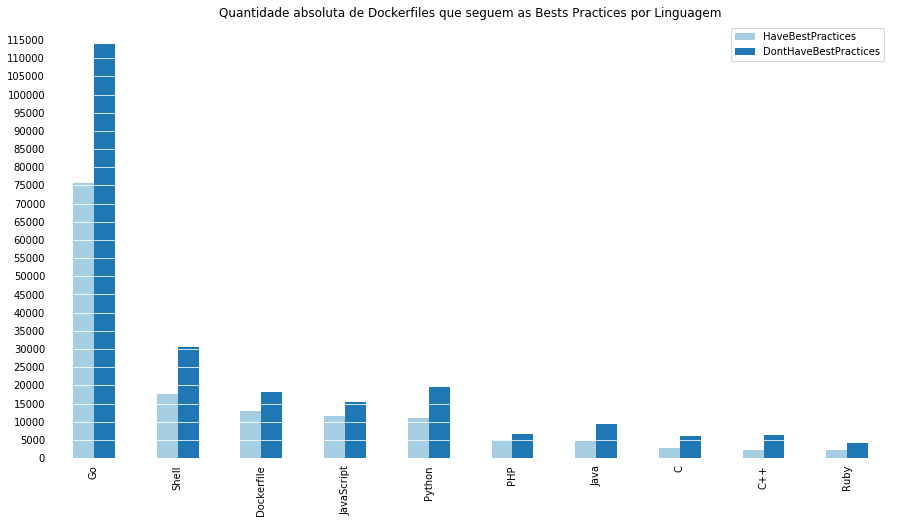

In [14]:
# figs, axes = plt.subplots(1,1,figsize=(15,4))
# dfWithDockerfiles[['MaxLang','HaveBestPractices']].plot.scatter(x='MaxLang',y='HaveBestPractices',ax=axes[0])
ax = dfGroupbyLangCount[['HaveBestPractices','DontHaveBestPractices']].nlargest(10,['HaveBestPractices','DontHaveBestPractices']).plot.bar(figsize=(15,8));
plt.xlabel('')
plt.locator_params(nbins=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title("Quantidade absoluta de Dockerfiles que seguem as Bests Practices por Linguagem")
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False)
ax.grid(axis='y',color='white',zorder=0,linestyle='-')
dfGroupbyLangCount[dfGroupbyLangCount['TotalDockerFiles'] > 100]

In [15]:
#dfGroupbyLangCount = dfGroupbyLangCount.drop(['não_%','sim_%'],axis=1)
dfGroupbyLangPercent = dfGroupbyLangCount.copy(deep=True)
dfGroupbyLangPercent['sim_%'] = dfGroupbyLangCount.apply(lambda row: (row['HaveBestPractices']*100)/row['TotalDockerFiles'], axis=1)
dfGroupbyLangPercent['não_%'] = dfGroupbyLangCount.apply(lambda row: (row['DontHaveBestPractices']*100)/row['TotalDockerFiles'], axis=1)
dfGroupbyLangPercent = dfGroupbyLangPercent[dfGroupbyLangPercent['TotalDockerFiles'] > 100]
dfGroupbyLangPercent.nlargest(10,['sim_%','não_%'])

,TotalDockerFiles,HaveBestPractices,DontHaveBestPractices,sim_%,não_%
MaxLang,,,,,
C#,2193,1435,758,65.435477,34.564523
ColdFusion,131,81,50,61.832061,38.167939
Kotlin,117,67,50,57.264957,42.735043
Assembly,323,184,139,56.965944,43.034056
Swift,1068,593,475,55.524345,44.475655
Emacs Lisp,118,63,55,53.389831,46.610169
TeX,122,62,60,50.819672,49.180328
PowerShell,248,125,123,50.403226,49.596774
R,310,149,161,48.064516,51.935484


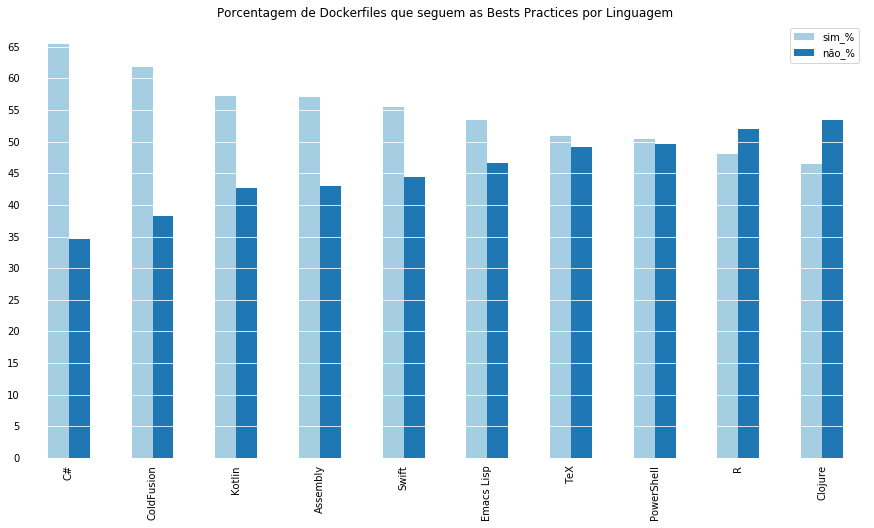

In [16]:
dfGroupbyLangPercent = dfGroupbyLangPercent.drop(['TotalDockerFiles','HaveBestPractices','DontHaveBestPractices'],axis=1)
ax = dfGroupbyLangPercent.nlargest(10,['sim_%','não_%']).plot.bar(figsize=(15,8));
plt.xlabel('')
plt.locator_params(nbins=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title("Porcentagem de Dockerfiles que seguem as Bests Practices por Linguagem")
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False)
ax.grid(axis='y',color='white',zorder=0,linestyle='-')

In [17]:
dfWithDockerfiles['create_year'] = pd.DatetimeIndex(dfWithDockerfiles['created_at']).year

In [18]:
# years = ['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018']
# dfGroupLangPerYear = dfWithDockerfiles.groupby(['create_year','MaxLang']).count()
# dfGroupLangPerYear = dfGroupLangPerYear.drop(['branches','commits','created_at','default_branch','forked_from',
#                                               'forks','_id_x','license','name','readme','releases','stars','updated_at',
#                                              'url','watchers','QtdLang','_id_y','config','path','repo','repoName',
#                                              'HaveBestPractices','ReasonOutBestPractices'],axis=1)
# dfGroupLangPerYear
# # pv.plot.bar(subplots=True,
# #                             layout=(8,3),
# #                             sharey=True,
# #                             figsize=(15,50))
# #dfGroupLangPerYear.dtypes
# pv
# dfRepos.drop(['create_year'],axis=1)
dfRepos['create_year'] = pd.DatetimeIndex(dfRepos['created_at']).year
dfRepos['create_year'] = dfRepos['create_year'].astype(str)
dfRepos['create_year'].replace('2018','2018-jan',inplace=True)

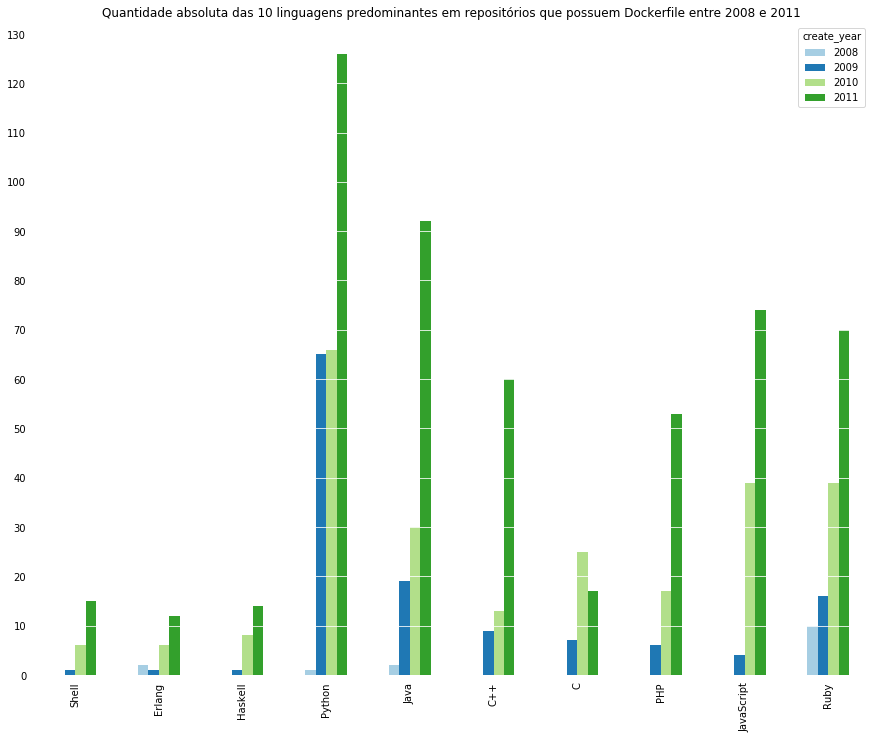

In [19]:
pv = pd.pivot_table(dfRepos, index='MaxLang', columns='create_year',
                    values='languagues', aggfunc='count')
df20082011 = pv[['2008','2009','2010','2011']].fillna(0)
df20082011 = df20082011[(df20082011.T != 0).any()]
ax = df20082011.nlargest(10,['2008','2009','2010','2011']).plot.bar(figsize=(15,12))
plt.xlabel('')
plt.locator_params(nbins=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title("Quantidade absoluta das 10 linguagens predominantes em repositórios que possuem Dockerfile entre 2008 e 2011")
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False)
ax.grid(axis='y',color='white',zorder=0,linestyle='-')

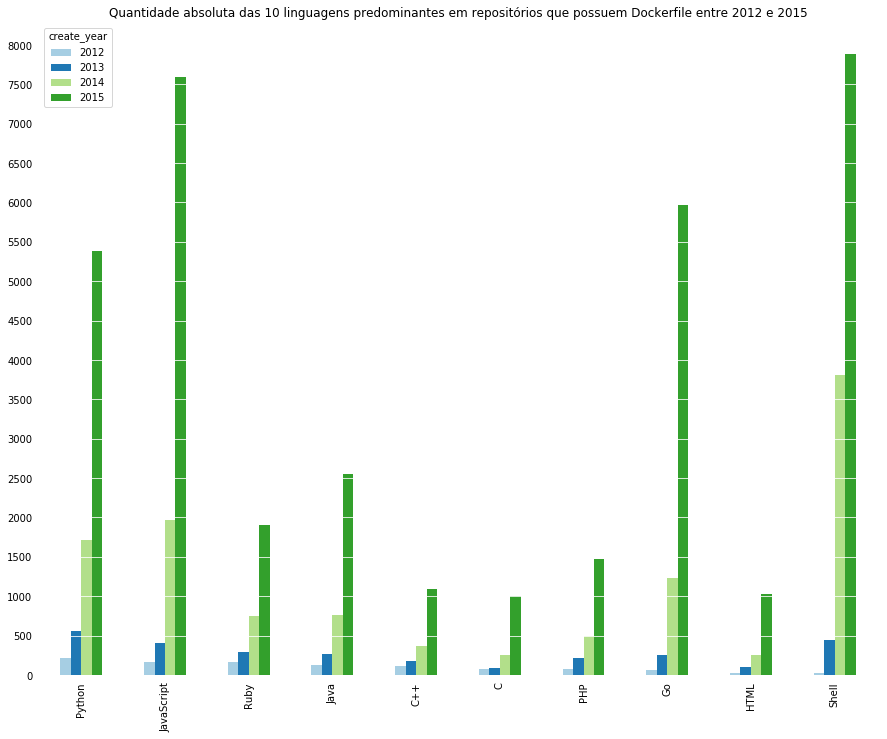

In [20]:
df20122015 = pv[['2012','2013','2014','2015']].fillna(0)
df20122015 = df20122015[(df20122015.T != 0).any()]
ax = df20122015.nlargest(10,['2012','2013','2014','2015']).plot.bar(figsize=(15,12))
plt.xlabel('')
plt.locator_params(nbins=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title("Quantidade absoluta das 10 linguagens predominantes em repositórios que possuem Dockerfile entre 2012 e 2015")
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False)
ax.grid(axis='y',color='white',zorder=0,linestyle='-')

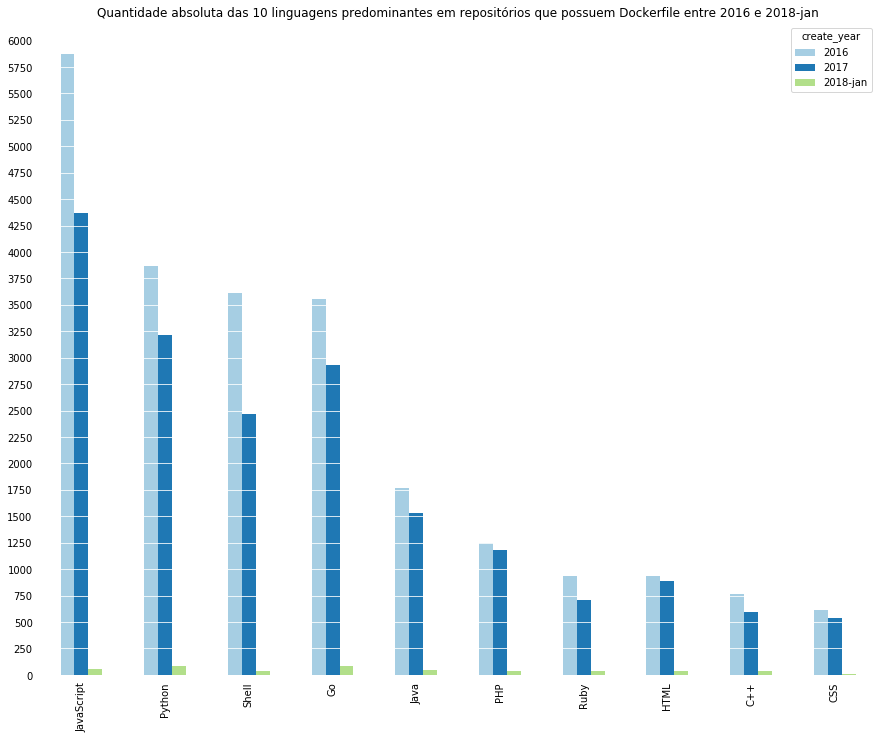

In [21]:
df20162018 = pv[['2016','2017','2018-jan']].fillna(0)
df20162018 = df20162018[(df20162018.T != 0).any()]
ax = df20162018.nlargest(10,['2016','2017','2018-jan']).plot.bar(figsize=(15,12))
plt.xlabel('')
plt.locator_params(nbins=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title("Quantidade absoluta das 10 linguagens predominantes em repositórios que possuem Dockerfile entre 2016 e 2018-jan")
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False)
ax.grid(axis='y',color='white',zorder=0,linestyle='-')

In [22]:
dfWithDockerfiles
dfWithDockerfiles['create_year'] = pd.DatetimeIndex(dfWithDockerfiles['created_at']).year
dfWithDockerfiles['create_year'] = dfWithDockerfiles['create_year'].astype(str)

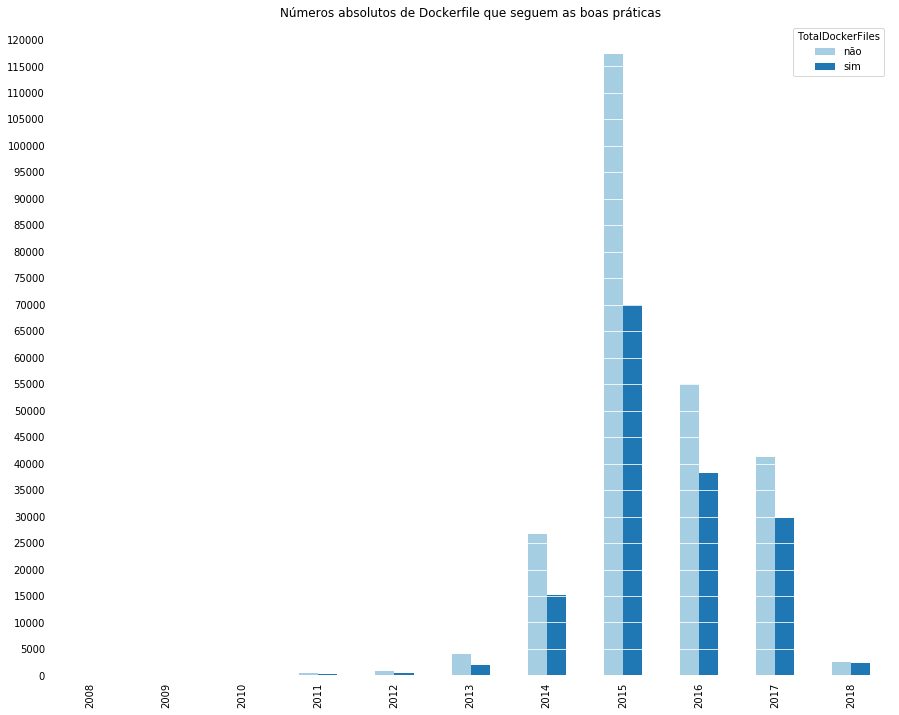

In [23]:
dfWithDockerfiles['TotalDockerFiles'] = dfWithDockerfiles['TotalDockerFiles'].replace(0,'não')
dfWithDockerfiles['TotalDockerFiles'] = dfWithDockerfiles['TotalDockerFiles'].replace(1,'sim')
dfWithDockerfiles.head()
pvDF = pd.pivot_table(dfWithDockerfiles, index='create_year', columns='TotalDockerFiles',
                    values='languagues', aggfunc='count')
ax = pvDF.plot.bar(figsize=(15,12))
plt.xlabel('')
plt.locator_params(nbins=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title("Números absolutos de Dockerfile que seguem as boas práticas")
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False)
ax.grid(axis='y',color='white',zorder=0,linestyle='-')

In [24]:
pvDF

TotalDockerFiles,não,sim
create_year,,
2008,9,1
2009,54,39
2010,125,90
2011,400,287
2012,852,538
2013,4017,2043
2014,26670,15144
2015,117313,69933
2016,54987,38317


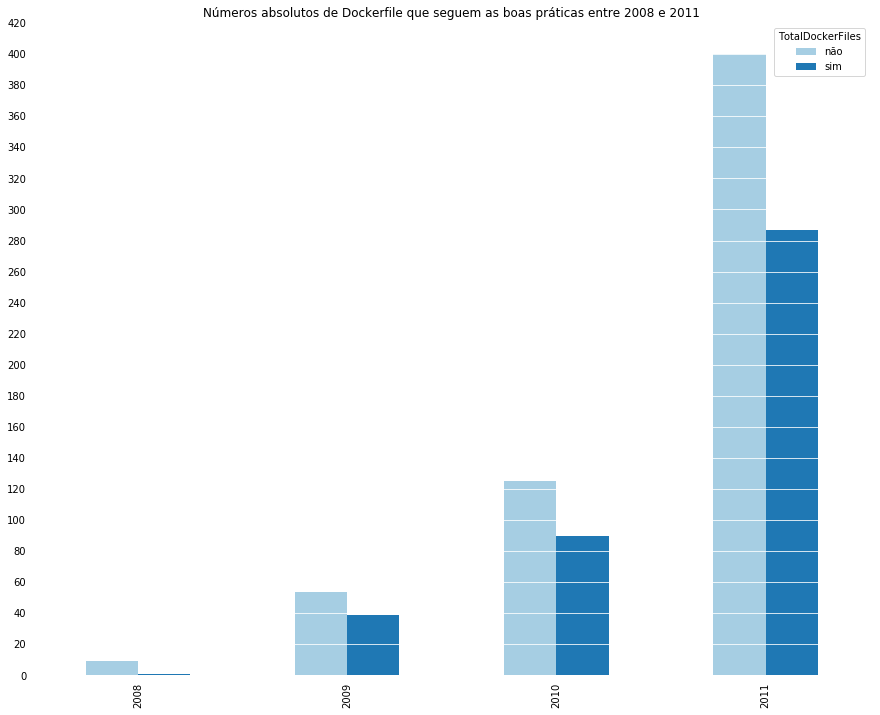

In [26]:
pvDF2 = pd.pivot_table(dfWithDockerfiles.loc[dfWithDockerfiles['create_year'].isin(['2008','2009','2010','2011'])],
                    index='create_year', columns='TotalDockerFiles',
                    values='languagues', aggfunc='count')
ax = pvDF2.plot.bar(figsize=(15,12))
plt.xlabel('')
plt.locator_params(nbins=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title("Números absolutos de Dockerfile que seguem as boas práticas entre 2008 e 2011")
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False)
ax.grid(axis='y',color='white',zorder=0,linestyle='-')

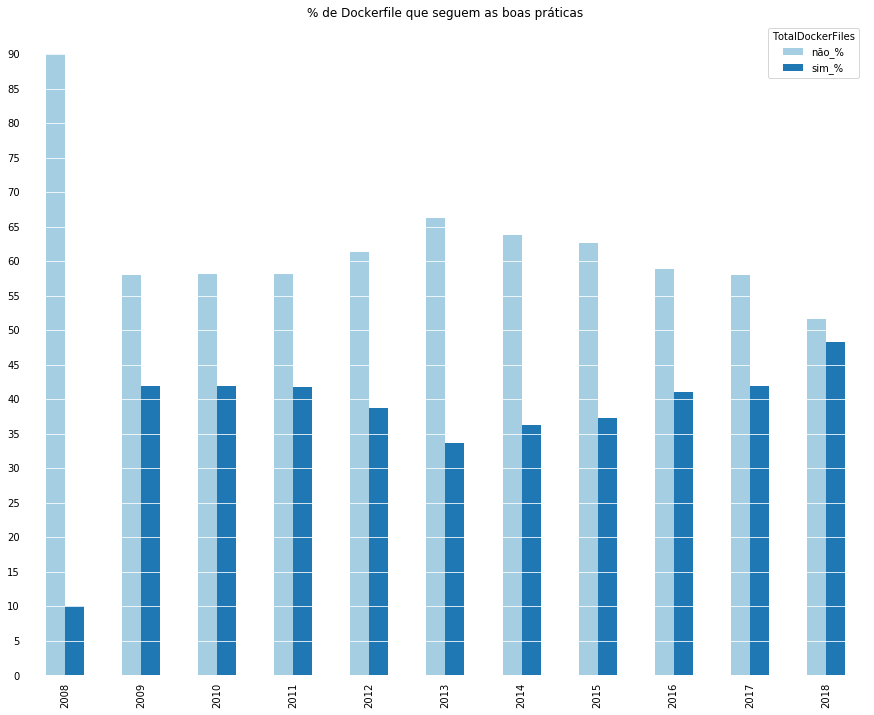

In [27]:
# def get_percentage(row):
#     return row
    
# dfConfigs['BestPractices'] = dfConfigs.apply(lambda row: label_best_practices(row), axis=1)
pvDF['não_%'] = pvDF.apply(lambda row: (row['não']*100)/(row['sim']+row['não']), axis=1)
pvDF['sim_%'] = pvDF.apply(lambda row: (row['sim']*100)/(row['sim']+row['não']), axis=1)
pvDF = pvDF.drop(['sim','não'],axis=1)
ax = pvDF.plot.bar(figsize=(15,12))
plt.xlabel('')
plt.locator_params(nbins=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title("% de Dockerfile que seguem as boas práticas") 
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False)
ax.grid(axis='y',color='white',zorder=0,linestyle='-')

In [28]:
dfConfigsOnlyBadPractices = dfConfigs.dropna()
# dfConfigsOnlyBadPractices

dfReasons = dfConfigsOnlyBadPractices['ReasonOutBestPractices'].apply(pd.Series)
dfReasons = dfReasons.fillna(0)

typesBadPractices = ['RUN apt-get update without install','RUN with pipe and without fail cautions',
                     'RUN with cd','RUN with sudo','RUN with apt-get upgrade or dist-upgrade',
                     'ADD with remote address','ADD without compressed file',
                     'WORKDIR without absolute path',
                     'Multi-stage build with last stage having more layers than previous stages']
totalBadPractices = []
for row in dfReasons.itertuples():
    rowBadPractices = [0]*9
    i=1
    while i < len(row) and row[i] != 0:
        rowBadPractices[typesBadPractices.index(row[i])]=1
        i += 1
    totalBadPractices.append(dict(zip([0,1,2,3,4,5,6,7,8],\
                                  rowBadPractices)))
    
newDfReasons = pd.DataFrame(totalBadPractices,columns=[0,1,2,3,4,5,6,7,8])
newDfReasons

,0,1,2,3,4,5,6,7,8
0,0,1,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0
4,0,1,0,1,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0
6,1,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,1,0,0
8,0,1,1,0,0,0,0,0,0
9,0,0,0,0,0,0,1,0,0


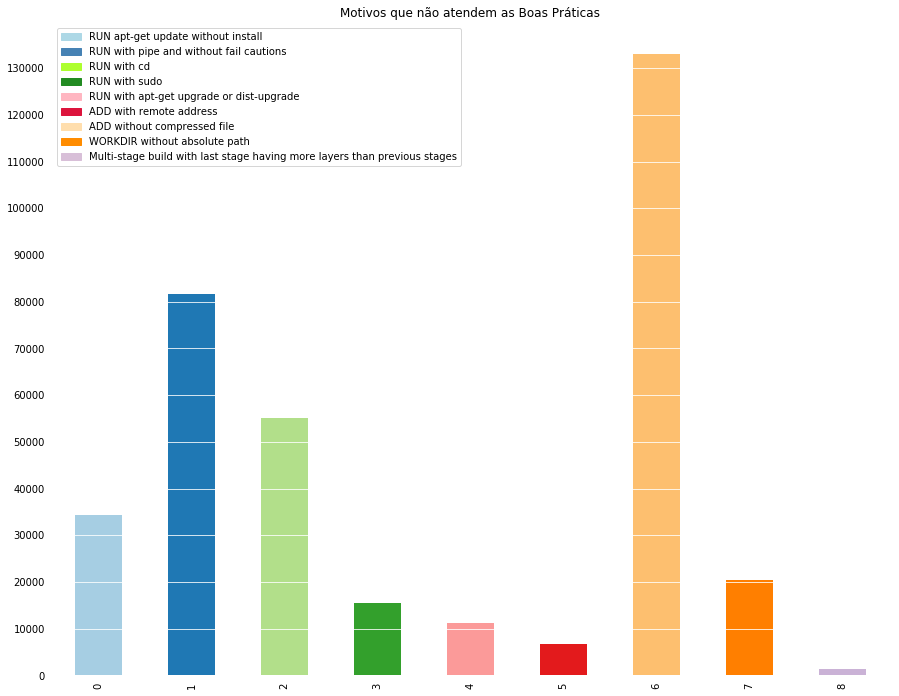

In [29]:

ax = newDfReasons.sum().plot.bar(figsize=(15,12))
plt.xlabel('')
plt.locator_params(nbins=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title("Motivos que não atendem as Boas Práticas") 
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False)

RUN0 = mpatches.Patch(color="LightBlue",label='RUN apt-get update without install')
RUN1 = mpatches.Patch(color="SteelBlue",label='RUN with pipe and without fail cautions')
RUN2 = mpatches.Patch(color="GreenYellow",label='RUN with cd')
RUN3 = mpatches.Patch(color="ForestGreen",label='RUN with sudo')
RUN4 = mpatches.Patch(color="LightPink",label='RUN with apt-get upgrade or dist-upgrade')
ADD5 = mpatches.Patch(color="Crimson",label='ADD with remote address')
ADD6 = mpatches.Patch(color="NavajoWhite",label='ADD without compressed file')
WORK7 = mpatches.Patch(color="DarkOrange",label='WORKDIR without absolute path')
MULT8 = mpatches.Patch(color="Thistle",label='Multi-stage build with last stage having more layers than previous stages')

ax.legend(handles=[RUN0,RUN1,RUN2,RUN3,RUN4,ADD5,ADD6,WORK7,MULT8],loc='upper left')
ax.grid(axis='y',color='white',zorder=0,linestyle='-')

In [30]:
test = pv.apply(lambda x: pd.Series({'media':x.mean(), 'desvp':x.std()}, 
                              index=['media','desvp']),axis=1)
#pv.nlargest(10,['2008', '2009', '2010', '2012', '2012', '2013', '2014', '2015', '2016', '2017', '2018-jan'])
#test.loc[ ['Go','Shell','Dockerfile','Python','JavaScript','PHP','Java','C','C++','Ruby'] , : ]
test.loc[ ['C#','ColdFusion','Kotlin','Assembly','Swift','Emacs Lisp','PowerShell','TeX','R','Vim script'] , : ]

,media,desvp
MaxLang,,
C#,120.000000,173.162737
ColdFusion,3.428571,2.507133
Kotlin,17.166667,20.014162
Assembly,10.285714,8.340949
Swift,59.500000,36.592349
Emacs Lisp,10.875000,7.845608
PowerShell,22.800000,19.370080
TeX,17.000000,17.990738
R,26.142857,27.491990


In [31]:
display(dfGroupbyLangCount[['TotalDockerFiles','HaveBestPractices']].cov())
display(dfGroupbyLangCount[['TotalDockerFiles','HaveBestPractices']].corr())
display(dfGroupbyLangCount[['TotalDockerFiles','HaveBestPractices']].corr(method='spearman'))
display(dfGroupbyLangCount.quantile([0.25, .5, .75]).T)
display(dfGroupbyLangCount.apply(lambda x: pd.Series({'amplitude': x.ptp(), 'min':x.min(), 'max':x.max()})).T)

,TotalDockerFiles,HaveBestPractices
TotalDockerFiles,2.289721e+08,9.077350e+07
HaveBestPractices,9.077350e+07,3.603066e+07


,TotalDockerFiles,HaveBestPractices
TotalDockerFiles,1.000000,0.999382
HaveBestPractices,0.999382,1.000000


,TotalDockerFiles,HaveBestPractices
TotalDockerFiles,1.00000,0.93121
HaveBestPractices,0.93121,1.00000


,0.25,0.5,0.75
TotalDockerFiles,2.0,9.5,101.50
HaveBestPractices,1.0,4.0,41.00
DontHaveBestPractices,1.0,5.5,49.25


,amplitude,min,max
TotalDockerFiles,189493,1,189494
HaveBestPractices,75543,0,75543
DontHaveBestPractices,113951,0,113951


In [38]:
testSum = pv.apply(lambda x: pd.Series({'Soma':x.sum()}, 
                              index=['Soma']),axis=1).sort_values('Soma')

,Soma
MaxLang,
Processing,1.0
SQL,1.0
Rascal,1.0
RAML,1.0
QMake,1.0
KiCad Layout,1.0
Pony,1.0
PAWN,1.0
EmberScript,1.0
